# Configuração do ambiente

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import numpy as np
from xgboost import XGBClassifier as XGB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  roc_auc_score, accuracy_score , balanced_accuracy_score , average_precision_score, recall_score ,precision_score , make_scorer
from  sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
import warnings

warnings.filterwarnings("ignore")

In [9]:
dados = pd.read_csv('https://raw.githubusercontent.com/Gabrieldpll/Hotel-Reservations/main/Hotel_Reservations_feature_engineering.csv')

In [10]:
dados.drop('Unnamed: 0' , axis  = 1 , inplace =True )

In [11]:
y = dados['booking_status'].map({'Canceled' : 1 ,'Not_Canceled' : 0})
X = dados.drop('booking_status',axis = 1)

In [12]:
metricas = {
            'balanced_acc' : 'balanced_accuracy',
            'recall' :  'recall',
            'precision' :  'precision',
            'f1' : 'f1'}

In [13]:
dados['required_car_parking_space'] = dados['required_car_parking_space'].astype('object')
dados['repeated_guest'] = dados['repeated_guest'].astype('object')
dados['feriado'] = dados['feriado'].astype('object')

In [14]:
from sklearn.model_selection import KFold
cv_shuffle = KFold(n_splits=10, shuffle=True,random_state = 13)

# Baseline

**Pre-Processamento de dados**


**Ajustando modelos com validação cruzada**

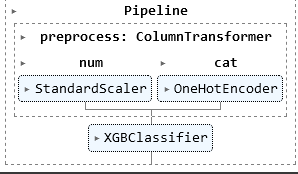

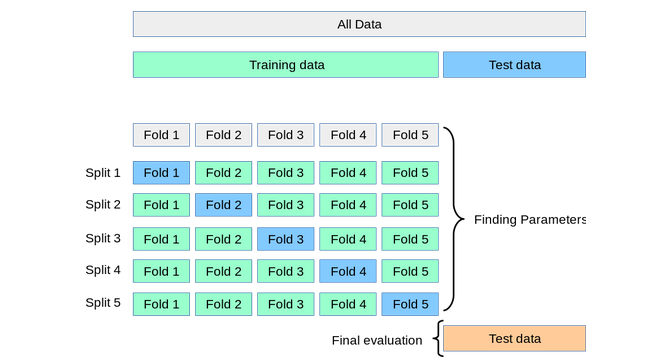

In [15]:
# Pré-Processamento

from sklearn.compose import  ColumnTransformer

numerical = dados.select_dtypes(include='number').columns
cat  = [i for i in  X.columns if i not in numerical]
t = [('num', StandardScaler(), numerical),
    ('cat',OneHotEncoder( sparse_output = False ,handle_unknown = 'infrequent_if_exist' ),cat)]
col_transform = ColumnTransformer(transformers=t)


In [16]:
modelos_baseline = dict()

In [17]:
# Função auxiliar dado um vetor com scores do k-fold me retorne ' media (dp)'
def report(score):
  dicionario = dict()
  for name, key in score.items():
    dicionario[str(name)] = f"{round(key.mean(),4)} ({round(key.std(),4)})"
  return dicionario


In [18]:
# Modelos a serem avaliados todos com a configuraçaõ default
modelos = [KNeighborsClassifier(),DecisionTreeClassifier(),SVC(),RandomForestClassifier(),XGB()]

In [19]:
# Para cada modelo avalie com k-fold CV
scores_baseline = dict()
for modelo in modelos:
  pipe = Pipeline([('preprocess', col_transform),('model',modelo)])
  scores = cross_validate(pipe, X, y, cv=cv_shuffle,scoring = metricas)
  modelos_baseline[str(modelo.__class__.__name__)] = report(scores)
  scores_baseline[str(modelo.__class__.__name__)] = scores

# Resumo e análise dos resultados


**Erro do tipo 1 ou falso positivo** O modelo preve como cancelado , mas era um cliente que não cancelou.

**Erro do tipo 2 ou falso negativa** O modelo preve como não cancelado , mas era um cliente que cancelou



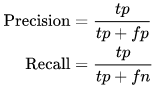

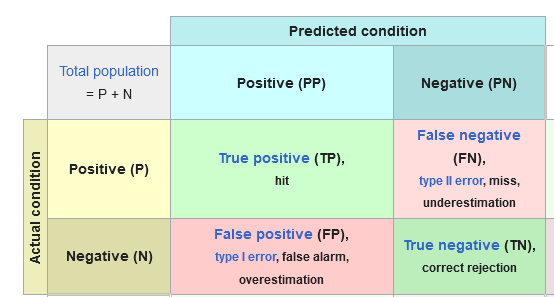

A acurácia não é uma métrica ideal para problemas em que o desbalanceamento esta presente, já que , por exemplo , um classificador que classifica todos clientes como  " não cancelados " teria 70% de acurácia.

**DECIDIR ENTRE QUAL ERRO É MAIS IMPORTANTE , se for erro tipo do tipo 1  esoclha  recall, se for erro do tipo 2  escolha precision  , ou tomar o a média harmônica entre o recall e precision (f1)**

In [20]:
df_baseline = pd.DataFrame.from_dict(scores_baseline).T


In [21]:
import matplotlib.pyplot as plt
def precision_recall_plot(x):
  fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'wspace': 0.3})
  ax1.boxplot(x['test_recall'].values, labels =  ['KNN' , "DCT","SVC","RF","XGB"])
  ax1.set_ylabel('Recall')
  ax2.boxplot(x['test_precision'].values, labels =  ['KNN' , "DCT", "SVC" ,"RF","XGB"])
  ax2.set_ylabel('Precision')
  ax3.boxplot(x['test_f1'].values,  labels = ['KNN' , "DCT", "SVC","RF","XGB"])
  ax3.set_ylabel('F1')

  plt.show()

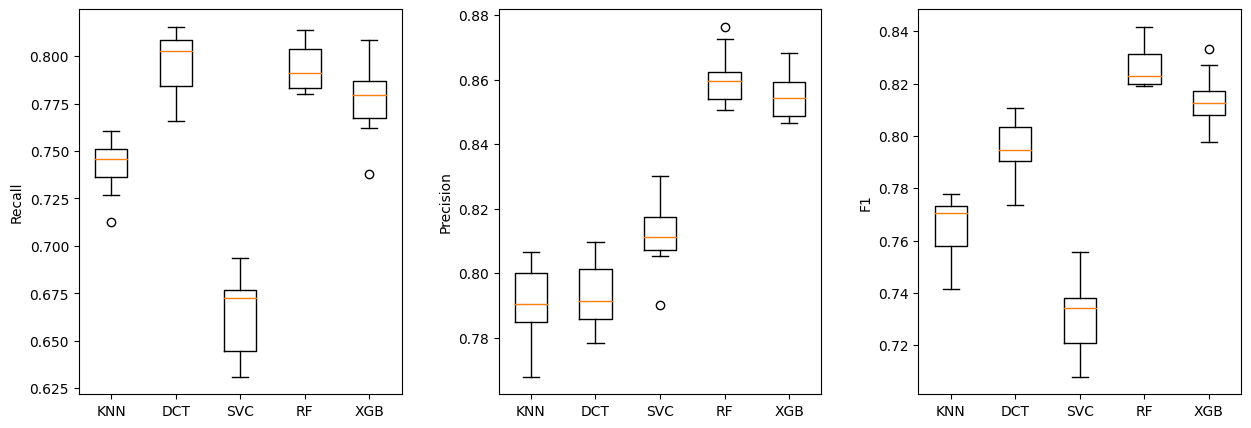

In [22]:
precision_recall_plot(df_baseline)


1.   **Modelos baseados em bagging(RF) e boosting (XGB) obteram melhores métricas**
2.   **Árvore de decissão é competitiva com o KNN ,  obtendo melhor recall e f1**






**Modelos baseados em árvore e suas extensões obtivera melhor desempenho**
<br>
OBS : para ser justo, deveríamos testar o svc com outros kernel


In [23]:
# Tempo de execução

baseline_report = pd.DataFrame.from_dict(modelos_baseline).T
baseline_report

,fit_time,score_time,test_balanced_acc,test_recall,test_precision,test_f1
KNeighborsClassifier,0.0754 (0.0172),0.9501 (0.2516),0.8234 (0.0083),0.7428 (0.0143),0.7902 (0.0122),0.7657 (0.0116)
DecisionTreeClassifier,0.2048 (0.007),0.0204 (0.0007),0.8476 (0.0085),0.7963 (0.0155),0.7933 (0.0101),0.7947 (0.0108)
SVC,43.7784 (2.082),4.6816 (0.6795),0.7942 (0.01),0.6632 (0.0196),0.8121 (0.0107),0.73 (0.0143)
RandomForestClassifier,3.307 (0.3111),0.1323 (0.0091),0.8657 (0.0058),0.7942 (0.0121),0.8604 (0.0081),0.8259 (0.0075)
XGBClassifier,5.2752 (0.8269),0.0323 (0.0006),0.8564 (0.0081),0.7771 (0.0184),0.855 (0.0068),0.814 (0.0097)


**KNN E DCT foram os mais rápidos**
<br>
**Muita demora no SVC (kenel não adequado e hyperparâmetros de penalização "não adequados" pode dificultar o problema de otimização)**

# SMOTE , EEN e SMOTEEEN

Ideia principal : **Na base de treinamento** criar e/ou remover exemplos artificiais semelhante , mas não duplicados, até que o conjunto de treinamento esteja balanceado. Então, ajustados o modelo no conjunto de treino + dados artificiais


*   SMOTE : Aumenta o conjunto de treinamento **criando mais exemplos da case minonitária**
*   EEN : Reduz a base de treinamento, **excluindo exemplos da classe majoritária**
*   SMOTEEEN : Aplica tanto o SMOTE quanto o EEN



In [24]:
modelos_imbalanced =  [DecisionTreeClassifier(max_depth = 12),RandomForestClassifier(),XGB()]
diconario_smote  = dict()
dicionario_EEN = dict()
dicionario_SMOTEEN = dict()



*   Desvantagens  : Amostrar ou remover outliers  / pontos de alavanca. Gerar uma novo conjunto de treinamento com uma densidade muito diferente do conjunto de teste ( isso é atrapalhar na generalização)





**O que diz a literatura : métodos de balanceamento de dados informativos, i.e ( que criam/removem exemplos, utilizando alguma heuristíca, são melhores do que reamostragem aleatória. Além disso, recomenda-se testar diferentes estratégias de balanceamento**

In [25]:
from imblearn.pipeline import Pipeline as imbpipe
from imblearn.over_sampling import SMOTE


In [26]:
scores_smote = dict()
for modelo in modelos_imbalanced:
  pipe = imbpipe([('preprocess', col_transform),('SMOTE', SMOTE(random_state = 42)), ('model',modelo)])
  scores = cross_validate(pipe, X, y, cv=cv_shuffle,scoring = metricas)
  diconario_smote[f"{str(modelo.__class__.__name__)}_SMOTE"] = report(scores)
  scores_smote[str(modelo.__class__.__name__)] = scores

In [27]:
df_SMOTE = pd.DataFrame.from_dict(scores_smote).T
df_smote_report =  pd.DataFrame.from_dict(diconario_smote).T

In [28]:
from imblearn.under_sampling import EditedNearestNeighbours as EEN

In [29]:
scores_een = dict()
for modelo in modelos_imbalanced:
  pipe_EEN = imbpipe([('preprocess', col_transform),('EEN', EEN( )), ('model',modelo)])
  scores = cross_validate(pipe_EEN, X, y, cv=cv_shuffle,scoring = metricas)
  dicionario_EEN[f"{str(modelo.__class__.__name__)}_EEN"] = report(scores)
  scores_een[str(modelo.__class__.__name__)] = scores

In [30]:
df_EEN = pd.DataFrame.from_dict(scores_een).T
df_EEN_report =  pd.DataFrame.from_dict(dicionario_EEN).T

In [31]:
from imblearn.combine import SMOTEENN
scores_smoteeen = dict()
for modelo in modelos_imbalanced:
  pipe_EEN_SMOTE = imbpipe([('preprocess', col_transform),('SMOTEENN', SMOTEENN( )), ('model',modelo)])
  scores = cross_validate(pipe_EEN_SMOTE, X, y, cv=cv_shuffle,scoring = metricas)
  dicionario_SMOTEEN[f"{str(modelo.__class__.__name__)}_SMOTEENN"] = report(scores)
  scores_smoteeen[str(modelo.__class__.__name__)] = scores

In [32]:
df_SMOTE_EEN = pd.DataFrame.from_dict(scores_smoteeen).T
df_SMOTEEN_report =  pd.DataFrame.from_dict(dicionario_SMOTEEN).T

In [33]:
dct_imbalanced = pd.concat([df_baseline,df_SMOTE,df_EEN,df_SMOTE_EEN ]).loc['DecisionTreeClassifier']
XGB_imbalanced = pd.concat([df_baseline,df_SMOTE,df_EEN,df_SMOTE_EEN ]).loc['XGBClassifier']
RF_imbalanced = pd.concat([df_baseline,df_SMOTE,df_EEN,df_SMOTE_EEN ]).loc['RandomForestClassifier']


In [34]:
def plot_imbalanced(dados,label,titulo):
  fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(15, 5),  sharey=True,gridspec_kw={'wspace': 0.3})
  ax1.boxplot(dados['test_recall'] ,
              labels = label )
  ax1.set_ylabel('Recall')
  ax2.boxplot(dados['test_precision'] ,
              labels = label )
  ax2.set_ylabel('precision')
  ax3.boxplot(dados['test_f1'] ,
              labels = label)
  ax3.set_ylabel('f1')
  fig.suptitle(titulo)
  plt.show()


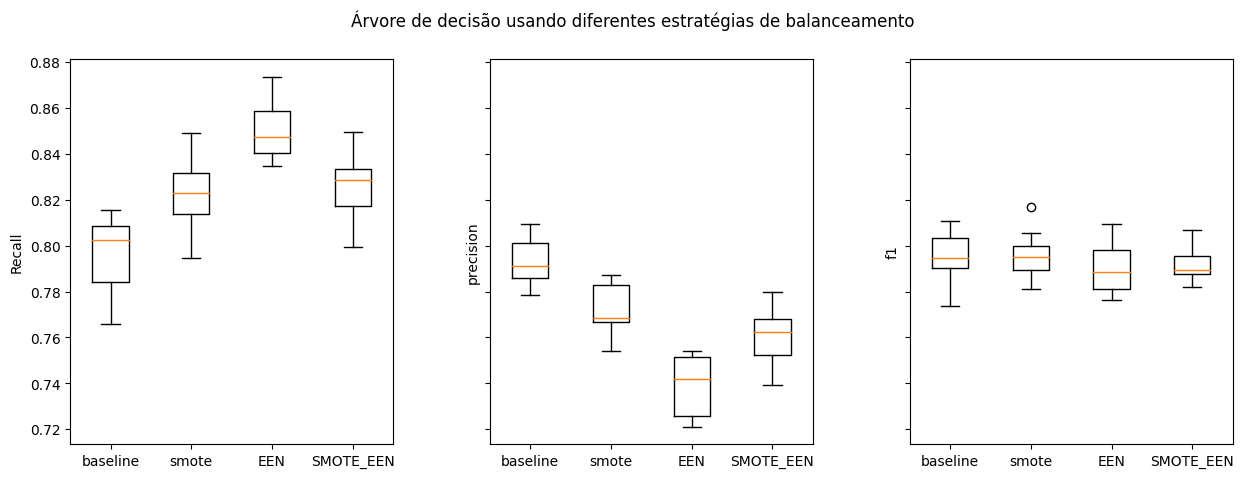

In [35]:
plot_imbalanced(dados = dct_imbalanced,label = ["baseline","smote","EEN","SMOTE_EEN"] , titulo = 'Árvore de decisão usando diferentes estratégias de balanceamento')

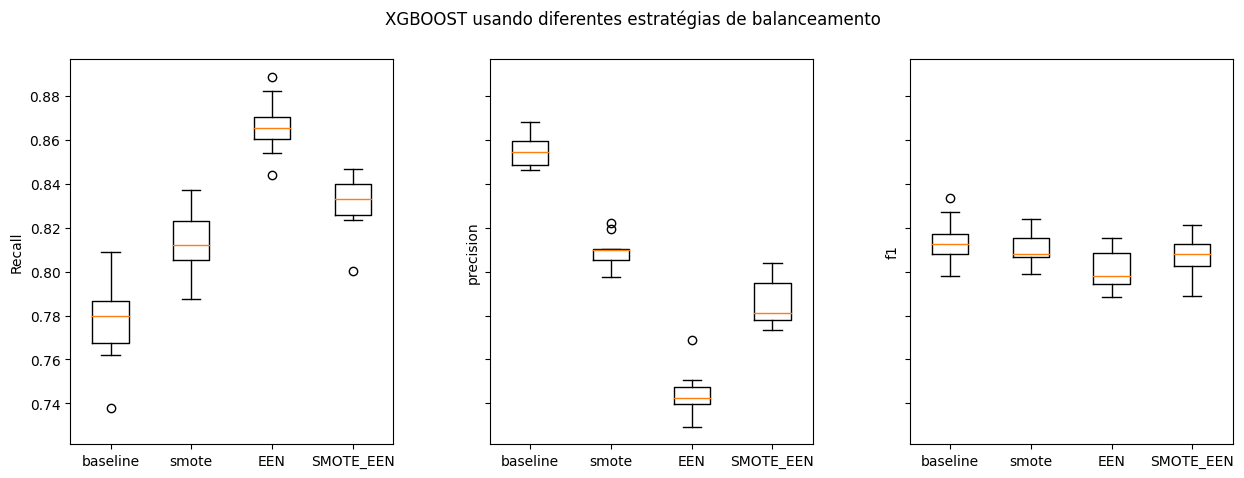

In [36]:
plot_imbalanced(dados = XGB_imbalanced, label = ["baseline","smote","EEN","SMOTE_EEN"] ,titulo = 'XGBOOST usando diferentes estratégias de balanceamento')

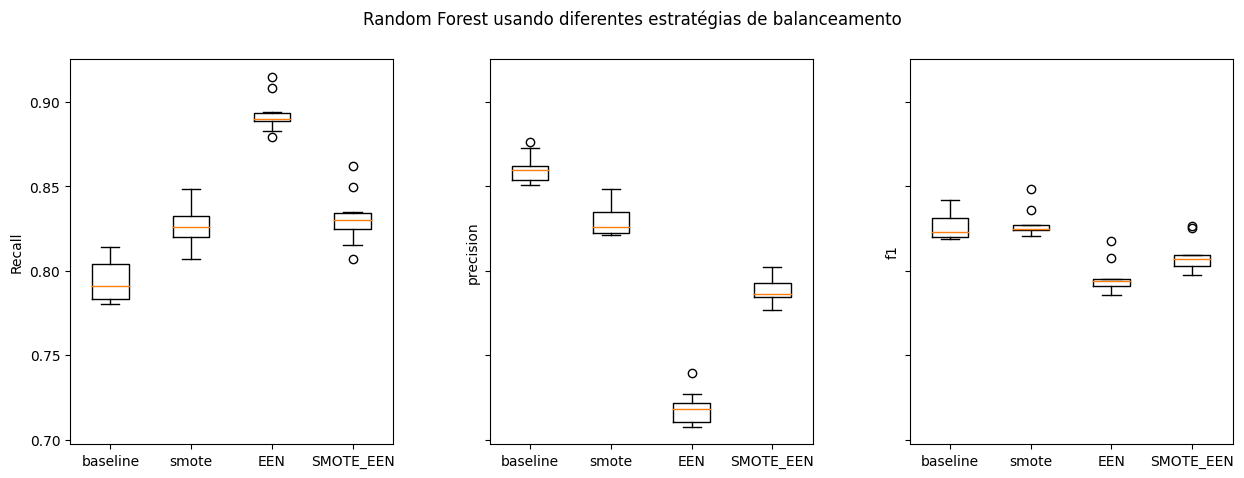

In [37]:

plot_imbalanced(dados = RF_imbalanced, label = ["baseline","smote","EEN","SMOTE_EEN"] ,titulo = 'Random Forest usando diferentes estratégias de balanceamento')

In [38]:
pd.DataFrame.from_dict(diconario_smote)


,DecisionTreeClassifier_SMOTE,RandomForestClassifier_SMOTE,XGBClassifier_SMOTE
fit_time,1.0376 (0.2683),5.6262 (0.4353),8.1594 (0.9074)
score_time,0.0219 (0.0042),0.1397 (0.0133),0.0323 (0.0013)
test_balanced_acc,0.8518 (0.0079),0.8718 (0.0062),0.8597 (0.0066)
test_recall,0.8221 (0.0154),0.8263 (0.0109),0.8129 (0.0146)
test_precision,0.7716 (0.0111),0.8297 (0.009),0.8091 (0.0071)
test_f1,0.796 (0.0099),0.8279 (0.0079),0.8109 (0.0079)


In [39]:
pd.DataFrame.from_dict(dicionario_EEN)


,DecisionTreeClassifier_EEN,RandomForestClassifier_EEN,XGBClassifier_EEN
fit_time,4.7811 (0.6422),6.9804 (0.6626),8.8183 (0.721)
score_time,0.0231 (0.004),0.1173 (0.0101),0.0377 (0.0172)
test_balanced_acc,0.8515 (0.0082),0.8611 (0.0074),0.8604 (0.0069)
test_recall,0.8495 (0.0119),0.8929 (0.0103),0.8661 (0.0122)
test_precision,0.7387 (0.0128),0.7181 (0.0094),0.744 (0.0104)
test_f1,0.7902 (0.011),0.796 (0.0091),0.8004 (0.0092)


In [40]:
pd.DataFrame.from_dict(dicionario_SMOTEEN)


,DecisionTreeClassifier_SMOTEENN,RandomForestClassifier_SMOTEENN,XGBClassifier_SMOTEENN
fit_time,13.1799 (0.0428),15.8014 (0.298),18.376 (0.8004)
score_time,0.0215 (0.0018),0.1113 (0.0097),0.0332 (0.001)
test_balanced_acc,0.8498 (0.0062),0.861 (0.0079),0.8604 (0.007)
test_recall,0.8262 (0.0148),0.8311 (0.0149),0.8314 (0.0128)
test_precision,0.7607 (0.0112),0.7879 (0.0072),0.7857 (0.0099)
test_f1,0.792 (0.0078),0.8089 (0.0092),0.8078 (0.0091)


# Overfiting em árvores de decisões.

O modelo pode ser sensível aos hyper parâmetros. Em especial, ároves muito ramificadas tendem a gerar overfit.
Antes de propormos modificações em  baseado em árvores (XGB e RF) , é preciso fornecer uma justificativa de partir de um modelo mais básico e interpretável (DCT) para modelos mais complexos (XGB e RF).

In [41]:
# Vizualização do overfit

f1_train = dict()
f1_test = dict()
k = [None,2,4,6,8,10,12,14,16,18]


for i in k:
    modelo = Pipeline([('preprocess', col_transform),('model',DecisionTreeClassifier(max_depth = i))])
    score_modelo = cross_validate( modelo , X, y, cv=5,scoring = 'f1', return_train_score = True)
    teste =  score_modelo['test_score']
    train = score_modelo['train_score']
    f1_train[str(i)] =  f"{round(train.mean(),4)} ({round(train.std(),4)})"
    f1_test[str(i)] = f"{round(teste.mean(),4)} ({round(teste.std(),4)})"


In [42]:
train_df = pd.DataFrame({'max_depth' : k , 'Train' : f1_train.values() })

In [43]:
test_df  = pd.DataFrame({'max_depth_1' : k , 'Test' : f1_test.values() })

In [44]:
pd.concat([train_df, test_df], axis=1).drop('max_depth_1', axis = 1)

,max_depth,Train,Test
0,NaN,0.9884 (0.0004),0.7869 (0.0088)
1,2.0,0.5432 (0.002),0.5431 (0.0083)
2,4.0,0.7011 (0.0075),0.6843 (0.0367)
3,6.0,0.7465 (0.0078),0.7294 (0.0029)
4,8.0,0.7844 (0.003),0.7738 (0.0089)
5,10.0,0.8137 (0.0018),0.7882 (0.0079)
6,12.0,0.8417 (0.0012),0.8006 (0.0088)
7,14.0,0.8687 (0.0021),0.8011 (0.0054)
8,16.0,0.8969 (0.0024),0.8004 (0.0087)
9,18.0,0.9212 (0.0026),0.794 (0.0108)


Quanto mais ramificada é a árvore maior as métricas no conjunto de treinamento , mas as métricas no conjunto de testes diminuem. **Dificuldade de generalização ou overfit**

Podemos otimizar alguns hyperparâmetros para evitar esse overfit.


1.   Profundidade máxima
2.   Porcentagem de exemplos miníma necessária para criar um novo ramo



Avaliação é feita utilizando nested-cross-validation e uma busca (no espaço completo de hyperparâmetros é realizada para obter o melhor conjunto de hyper parâmetros)



In [45]:
dct_pipe = Pipeline([('preprocess', col_transform),('model',DecisionTreeClassifier())])


In [46]:
# https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
from sklearn.model_selection import GridSearchCV

dct_pipe = Pipeline([('preprocess', col_transform),('model',DecisionTreeClassifier())])
# Espaço da busca
space = {'model__max_depth' :  k,
         'model__criterion'  :  ['gini', 'entropy'],
         'model__min_samples_split' : [2,0.01,0.1,0.3,0.5,0.7,0.9] # 2 default
}

# Cross validation para realizar a busca
cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
# Realiza a busca no conjutno de validação
search = GridSearchCV(dct_pipe, space, scoring='f1', n_jobs= -1, cv=cv_inner, refit=True)
# Avaliamos o resultado
scores_dct = cross_validate(search, X, y, scoring= metricas , cv=cv_shuffle, n_jobs=-1, return_train_score=False )

In [50]:
dct_tuned_report = pd.DataFrame({'DCT tuned' :report(scores_dct)}).T

In [51]:
# resultados dct com hyperparametros tunados
report(scores_dct)

{'fit_time': '83.4556 (1.6053)',
 'score_time': '0.0427 (0.015)',
 'test_balanced_acc': '0.8516 (0.0066)',
 'test_recall': '0.7856 (0.0146)',
 'test_precision': '0.8228 (0.0092)',
 'test_f1': '0.8037 (0.0082)'}

In [48]:
# dct baseline
modelos_baseline['DecisionTreeClassifier']

{'fit_time': '0.2048 (0.007)',
 'score_time': '0.0204 (0.0007)',
 'test_balanced_acc': '0.8476 (0.0085)',
 'test_recall': '0.7963 (0.0155)',
 'test_precision': '0.7933 (0.0101)',
 'test_f1': '0.7947 (0.0108)'}

**Melhores do que o dct do baseline** <br>  Uma outra estratégia  é adotar estratégias de bagging e boosting ( já foi feita no baseline , (XGB e RF)

# Modificação do random forest e estudo de um hyperparâmetro do  xgboost

**Outra solução para o problema de balanceamento é propor modificações nos algoritmos para que eles se adaptem ao problema do desbalanceamento**

**Proposta random florest**

In [52]:
from imblearn.ensemble import BalancedRandomForestClassifier
pipe = Pipeline([('preprocess', col_transform),('model',BalancedRandomForestClassifier())])
scores = cross_validate(pipe, X, y, cv=cv_shuffle,scoring = metricas)
report(scores)

{'fit_time': '3.6089 (0.4134)',
 'score_time': '0.1256 (0.0081)',
 'test_balanced_acc': '0.8762 (0.0064)',
 'test_recall': '0.866 (0.0122)',
 'test_precision': '0.7879 (0.0078)',
 'test_f1': '0.825 (0.007)'}

In [53]:
df_imbalanced_rf = pd.DataFrame({'RandomForestClassifier' :scores}).T

In [54]:
df_rf_completo = pd.concat([RF_imbalanced,df_imbalanced_rf])

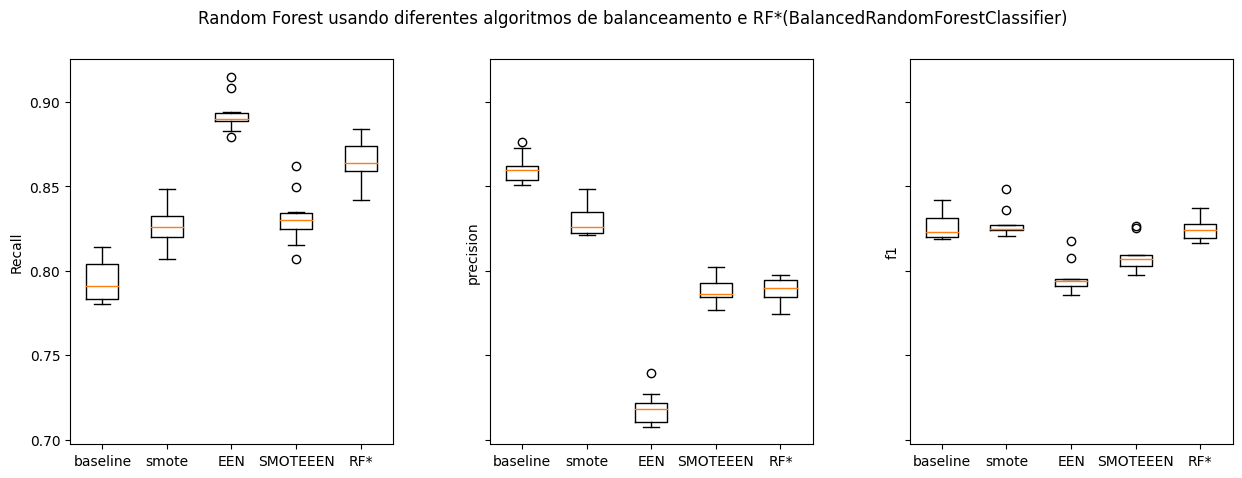

In [55]:
plot_imbalanced(dados = df_rf_completo,label = ["baseline","smote","EEN","SMOTEEEN","RF*"] , titulo = 'Random Forest usando diferentes algoritmos de balanceamento e RF*(BalancedRandomForestClassifier)')

In [56]:
balancedrf_report_df = pd.DataFrame({'BalancedRandomForestClassifier' :report(scores)}).T
balancedrf_report_df

,fit_time,score_time,test_balanced_acc,test_f1,test_precision,test_recall
BalancedRandomForestClassifier,3.6089 (0.4134),0.1256 (0.0081),0.8762 (0.0064),0.825 (0.007),0.7879 (0.0078),0.866 (0.0122)


**Proposta XGB**

In [57]:
scale_pos_weight = []
recall = []
precision = []
f1 = []
for i in np.linspace(0.1,10,50):
    xgb =  Pipeline([('preprocess', col_transform),('model',XGB(random_state = 42 ,scale_pos_weight = i,tree_method  = 'hist'))])
    scores_xgboost = cross_validate( xgb , X, y, cv=5,scoring = metricas)
    f = scores_xgboost['test_f1'].mean()
    p = scores_xgboost['test_precision'].mean()
    r = scores_xgboost['test_recall'].mean()
    scale_pos_weight.append(i)
    recall.append(r)
    precision.append(p)
    f1.append(f)

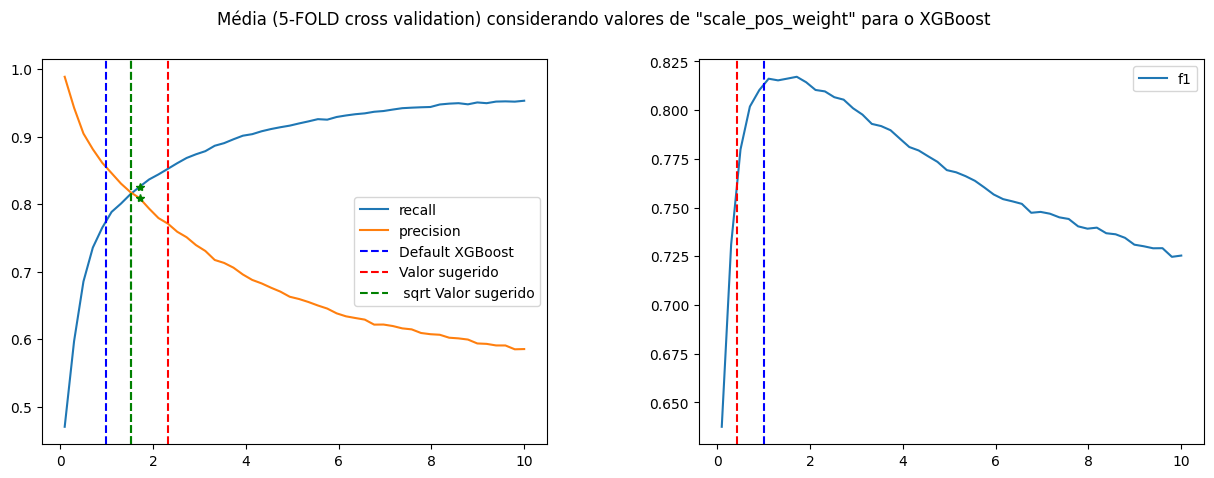

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'wspace': 0.3})
index_max = f1.index(max(f1))

ax1.plot(scale_pos_weight,recall,label = "recall")
ax1.plot(scale_pos_weight,precision, label = "precision")
ax1.plot(scale_pos_weight[index_max], precision[index_max], 'g*')
ax1.plot(scale_pos_weight[index_max], recall[index_max], 'g*')
ax1.axvline(x = 1 ,color='b', linestyle='--',label = 'Default XGBoost')
ax1.axvline(x = 70/30,color='r', linestyle='--', label = 'Valor sugerido')
ax1.axvline(x = (70/30)**0.5,color='g', linestyle='--', label =  ' sqrt Valor sugerido')

ax1.legend()

ax2.plot(scale_pos_weight,f1, label  = "f1")
ax2.axvline(x = 1 ,color='b', linestyle='--')
ax2.axvline(x = 30/70,color='r', linestyle='--')
ax1.axvline(x = (70/30)**0.5,color='g', linestyle='--', label =  ' sqrt Valor sugerido')

ax2.legend()
fig.suptitle('Média (5-FOLD cross validation) considerando valores de "scale_pos_weight" para o XGBoost')
plt.show()



1.   O default do xgb forneceu o melhor resultado em termos de F1 SCORE
2.   A sugestão obteve maior recall
3.   Scale pos weight pode ser útil para lidar com o dilema RECALL VS PRECISION
4.   Não é recomendado valores extremos desse hyperparâmetro
5.   Pode ser otimizado para obter melhor métricas


In [59]:
xgb_scaled =  Pipeline([('preprocess', col_transform),('model',XGB(random_state = 42 ,scale_pos_weight = 70/30,tree_method  = 'hist'))])
scores_xgb_scaled = cross_validate(xgb_scaled, X, y, cv=cv_shuffle,scoring = metricas)
df_imbalanced_XGB_scale = pd.DataFrame({'RandomForestClassifier' :scores_xgb_scaled}).T
df_XGB_completo = pd.concat([XGB_imbalanced, df_imbalanced_XGB_scale])


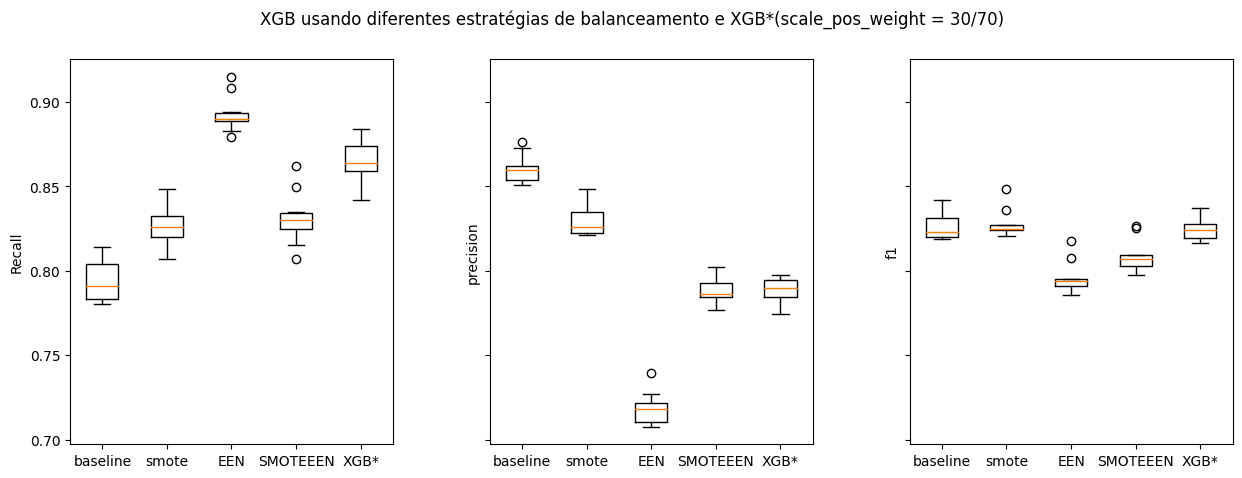

In [60]:
plot_imbalanced(dados = df_rf_completo,label = ["baseline","smote","EEN","SMOTEEEN","XGB*"] , titulo = 'XGB usando diferentes estratégias de balanceamento e XGB*(scale_pos_weight = 30/70)')

In [61]:
XGB_scale_report_df = pd.DataFrame({'XGBoost_scale' :report(scores_xgb_scaled)}).T
XGB_scale_report_df

,fit_time,score_time,test_balanced_acc,test_f1,test_precision,test_recall
XGBoost_scale,0.6907 (0.5599),0.0343 (0.0036),0.8665 (0.0043),0.8121 (0.0068),0.7732 (0.011),0.8553 (0.0091)


# VotingClassifier




In [62]:
from sklearn.ensemble import VotingClassifier


vote = VotingClassifier([('xgb-scale', XGB(random_state = 42,scale_pos_weight = 30/70,tree_method  = 'hist')),
                          ('balanced_rf',BalancedRandomForestClassifier(random_state = 42))],
                        voting = 'soft')

voting1 =  Pipeline([('preprocess', col_transform),('model',vote)])

scores_vote1 = cross_validate(voting1, X, y, cv=cv_shuffle,scoring = metricas)


In [63]:
vote_df_report = pd.DataFrame({'Vote' :report(scores_vote1)}).T
vote_df_report

,fit_time,score_time,test_balanced_acc,test_f1,test_precision,test_recall
Vote,4.1066 (0.3265),0.1494 (0.0212),0.866 (0.0082),0.8284 (0.0099),0.8749 (0.0054),0.7869 (0.0172)


In [64]:
pipe = Pipeline([('preprocess', col_transform),('model',SVC(gamma='auto'))])
scores = cross_validate(pipe, X, y, cv=cv_shuffle,scoring = metricas)

# Melhores modelos

In [65]:
df_final_resumo = pd.concat( [ baseline_report,balancedrf_report_df ,  dct_tuned_report ,XGB_scale_report_df , vote_df_report,df_smote_report , df_SMOTEEN_report , df_EEN_report])#.sort_values(by = "test_f1", axis = 1 , ascending = True)

In [66]:
df_final_resumo.columns

Index(['fit_time', 'score_time', 'test_balanced_acc', 'test_recall',
       'test_precision', 'test_f1'],
      dtype='object')

In [67]:
df_final_resumo.sort_values(by = 'test_f1', ascending = False)[0:5]

,fit_time,score_time,test_balanced_acc,test_recall,test_precision,test_f1
Vote,4.1066 (0.3265),0.1494 (0.0212),0.866 (0.0082),0.7869 (0.0172),0.8749 (0.0054),0.8284 (0.0099)
RandomForestClassifier_SMOTE,5.6262 (0.4353),0.1397 (0.0133),0.8718 (0.0062),0.8263 (0.0109),0.8297 (0.009),0.8279 (0.0079)
RandomForestClassifier,3.307 (0.3111),0.1323 (0.0091),0.8657 (0.0058),0.7942 (0.0121),0.8604 (0.0081),0.8259 (0.0075)
BalancedRandomForestClassifier,3.6089 (0.4134),0.1256 (0.0081),0.8762 (0.0064),0.866 (0.0122),0.7879 (0.0078),0.825 (0.007)
XGBClassifier,5.2752 (0.8269),0.0323 (0.0006),0.8564 (0.0081),0.7771 (0.0184),0.855 (0.0068),0.814 (0.0097)


In [71]:
df_final_resumo.sort_values(by = 'test_recall', ascending = False)[0:5].drop(['score_time'],axis = 1)

,fit_time,test_balanced_acc,test_recall,test_precision,test_f1
RandomForestClassifier_EEN,6.9804 (0.6626),0.8611 (0.0074),0.8929 (0.0103),0.7181 (0.0094),0.796 (0.0091)
XGBClassifier_EEN,8.8183 (0.721),0.8604 (0.0069),0.8661 (0.0122),0.744 (0.0104),0.8004 (0.0092)
BalancedRandomForestClassifier,3.6089 (0.4134),0.8762 (0.0064),0.866 (0.0122),0.7879 (0.0078),0.825 (0.007)
XGBoost_scale,0.6907 (0.5599),0.8665 (0.0043),0.8553 (0.0091),0.7732 (0.011),0.8121 (0.0068)
DecisionTreeClassifier_EEN,4.7811 (0.6422),0.8515 (0.0082),0.8495 (0.0119),0.7387 (0.0128),0.7902 (0.011)


In [73]:
df_final_resumo.sort_values(by = 'test_precision', ascending = False)[0:5].drop(['score_time'],axis = 1)

,fit_time,test_balanced_acc,test_recall,test_precision,test_f1
Vote,4.1066 (0.3265),0.866 (0.0082),0.7869 (0.0172),0.8749 (0.0054),0.8284 (0.0099)
RandomForestClassifier,3.307 (0.3111),0.8657 (0.0058),0.7942 (0.0121),0.8604 (0.0081),0.8259 (0.0075)
XGBClassifier,5.2752 (0.8269),0.8564 (0.0081),0.7771 (0.0184),0.855 (0.0068),0.814 (0.0097)
RandomForestClassifier_SMOTE,5.6262 (0.4353),0.8718 (0.0062),0.8263 (0.0109),0.8297 (0.009),0.8279 (0.0079)
DCT tuned,83.4556 (1.6053),0.8516 (0.0066),0.7856 (0.0146),0.8228 (0.0092),0.8037 (0.0082)


In [74]:
df_final_resumo.sort_values(by = 'test_balanced_acc', ascending = False)[0:5].drop(['score_time'],axis = 1)

,fit_time,test_balanced_acc,test_recall,test_precision,test_f1
BalancedRandomForestClassifier,3.6089 (0.4134),0.8762 (0.0064),0.866 (0.0122),0.7879 (0.0078),0.825 (0.007)
RandomForestClassifier_SMOTE,5.6262 (0.4353),0.8718 (0.0062),0.8263 (0.0109),0.8297 (0.009),0.8279 (0.0079)
XGBoost_scale,0.6907 (0.5599),0.8665 (0.0043),0.8553 (0.0091),0.7732 (0.011),0.8121 (0.0068)
Vote,4.1066 (0.3265),0.866 (0.0082),0.7869 (0.0172),0.8749 (0.0054),0.8284 (0.0099)
RandomForestClassifier,3.307 (0.3111),0.8657 (0.0058),0.7942 (0.0121),0.8604 (0.0081),0.8259 (0.0075)


**Próximos passos**


1.   Ajustar um modelo de regressão logística e fazer análise de influência
2.   Adotar outras metódos de otimização de hyper parâmetros
3.   Utilizar ténicas de aprendizado de máquina explicável (SHAP,LIME, etc)


